# Source to Target Comparator

1. We have devloped this comparator for performing unit testing in case of migratiion projects.
2. In all migration projects, in the end, we want to compare source and target data.
3. This utility can be used to compare source and target data.
4. Source and target can be anything which supported by SLING CLI. It can be files(csv, parquet, json etc). It can also be databases like MSSQL, MYSQL, Oracle or Snowflake etc.
5. This utility extract data from source and targets and create parquet files out of them and then compare it.
6. To use this utility, one needs to know about SLING CLI and duckdb.


## Step-1 update the connections in connection/sling/env.yaml file. please refer [SLING CLI](https://docs.slingdata.io/sling-cli/environment#sling-env-file-env.yaml) documentatation for connection parameters for specifc database or files.

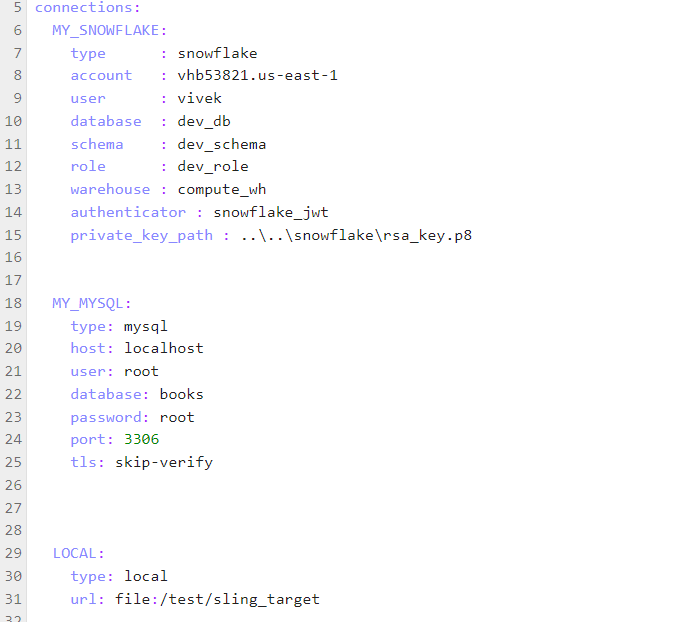

## Step-2 update the src_replication.yaml file with the source connection name and fully qualified table/file name in the workflows folder.

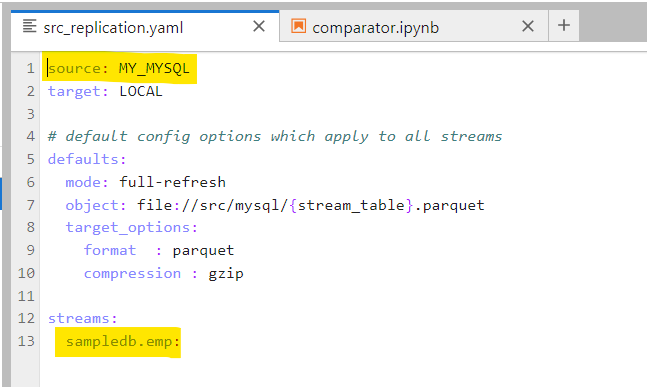

## Step-3 update the tgt_replication.yaml file with the target connection name and fully qualified table/file name in the workflows folder.

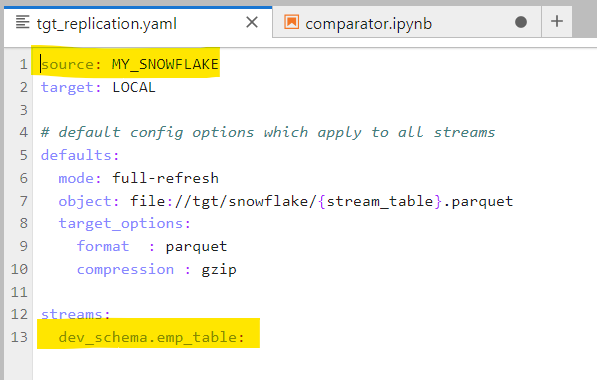

## Step-4 once above given steps are completed, we can to install python dependecies

In [30]:
! pip install -r requirements.txt

## Step-5 set SLING_HOME_DIR environment varaiable with value where env.yaml file has been kept.

In [31]:
import os
os.environ["SLING_HOME_DIR"] = "connection\sling"

## Step-6 we can test our SRC connections by dicovering streams.

In [32]:
! sling conns discover MY_MYSQL books.*

+-----+----------+--------------------+------------------------------------------------------+-------+---------+
|   # | DATABASE | SCHEMA             | NAME                                                 | TYPE  | COLUMNS |
+-----+----------+--------------------+------------------------------------------------------+-------+---------+
|   1 | books    | books              | authors                                              | table |       3 |
|   2 | books    | employees          | current_dept_emp                                     | view  |       4 |
|   3 | books    | employees          | departments                                          | table |       2 |
|   4 | books    | employees          | dept_emp_latest_date                                 | view  |       3 |
|   5 | books    | employees          | dept_emp                                             | table |       4 |
|   6 | books    | employees          | dept_manager                                         | t

## Step-7 we can test our TGT connections by dicovering streams.

In [33]:
! sling conns discover MY_SNOWFLAKE dev_db.*

+----+----------+--------------------+---------------------------------+-------+---------+
|  # | DATABASE | SCHEMA             | NAME                            | TYPE  | COLUMNS |
+----+----------+--------------------+---------------------------------+-------+---------+
|  1 | DEV_DB   | DEV_SCHEMA         | EMP                             | TABLE |       7 |
|  2 | DEV_DB   | DEV_SCHEMA         | EMP_TABLE                       | TABLE |       7 |
|  3 | DEV_DB   | DEV_SCHEMA         | TEST                            | TABLE |       2 |
|  4 | DEV_DB   | INFORMATION_SCHEMA | APPLICABLE_ROLES                | VIEW  |       4 |
|  5 | DEV_DB   | INFORMATION_SCHEMA | CLASSES                         | VIEW  |       9 |
|  6 | DEV_DB   | INFORMATION_SCHEMA | CLASS_INSTANCES                 | VIEW  |      11 |
|  7 | DEV_DB   | INFORMATION_SCHEMA | CLASS_INSTANCE_FUNCTIONS        | VIEW  |      29 |
|  8 | DEV_DB   | INFORMATION_SCHEMA | CLASS_INSTANCE_PROCEDURES       | VIEW  |      17 |

## Step-8 Once connections are tested, We can run the following script to download data from the source and target on parquet format and the compare.

### Step-8.1 import libraries

In [34]:
import yaml
import duckdb
import shutil
from sling import Replication

### Step-8.2 Mandatory deletion of src and tgt directories

In [35]:
try:
    shutil.rmtree('src')
    shutil.rmtree('tgt')
except OSError as e:
    print("Error: %s - %s." % (e.filename, e.strerror))

### Step-8.2 read src_replication.yaml and tgt_replication.yaml files and create confguration objects

In [36]:
with open('workflows/src_replication.yaml') as file:
  src_config = yaml.load(file, Loader=yaml.FullLoader)

with open('workflows/tgt_replication.yaml') as file:
  tgt_config = yaml.load(file, Loader=yaml.FullLoader)

### Step-8.3 create Sling replication objects for both source and target

In [37]:
src_replication = Replication(**src_config)
tgt_replication = Replication(**tgt_config)

### Step-8.4 run source replication. This will generate the source parquet file in location given src_replication.yaml file.

In [38]:
try:
    src_replication.run()
except Exception as e:
    print("This is the exception caught in source replication")
    raise e

12:20AM INF Sling Replication [1 streams] | MY_MYSQL -> LOCAL

12:20AM INF [1 / 1] running stream sampledb.emp
12:20AM INF connecting to source database (mysql)
12:20AM INF reading from source database
12:20AM INF writing to target file system (file)
12:20AM INF wrote 100 rows [659 r/s] to file://src/my_mysql/sampledb/emp/file_2024_10_25_002058.parquet
12:20AM INF execution succeeded

12:21AM INF Sling Replication Completed in 1s | MY_MYSQL -> LOCAL | 1 Successes | 0 Failures



### Step-8.5 run target replication. This will generate the target parquet file in location given tgt_replication.yaml file.

In [39]:
try:
    tgt_replication.run()
except Exception as e:
    print("This is the exception caught in target replication")
    raise e

12:21AM INF Sling Replication [1 streams] | MY_SNOWFLAKE -> LOCAL

12:21AM INF [1 / 1] running stream dev_schema.emp_table
12:21AM INF connecting to source database (snowflake)
12:21AM INF reading from source database
12:21AM INF writing to target file system (file)
12:21AM INF wrote 100 rows [6 r/s] to file://tgt/my_snowflake/DEV_SCHEMA/EMP_TABLE/file_2024_10_25_002100.parquet
12:21AM INF execution succeeded

12:21AM INF Sling Replication Completed in 18s | MY_SNOWFLAKE -> LOCAL | 1 Successes | 0 Failures

FYI there is a new sling version released (1.2.22). Please run `sling update`


### Step-8.6 creating source and target files path

In [40]:
src_schema_name = list(src_replication.streams.keys())[0].split('.')[0]
src_table_name = list(src_replication.streams.keys())[0].split('.')[1]
src_path = f"src\{src_replication.source.lower()}\{src_schema_name}\{src_table_name}"

tgt_schema_name = list(tgt_replication.streams.keys())[0].split('.')[0].upper()
tgt_table_name = list(tgt_replication.streams.keys())[0].split('.')[1].upper()
tgt_path = f"tgt\{tgt_replication.source.lower()}\{tgt_schema_name}\{tgt_table_name}"

# The generated Source file path and Target file path must match the paths where Sling has generated parquet files in step 8.4 and 8.5.
# If not, we have to modify scripts in this cell to match that paths.

print(f"source files path: {src_path}")
print(f"target files path: {tgt_path}")


source files path: src\my_mysql\sampledb\emp
target files path: tgt\my_snowflake\DEV_SCHEMA\EMP_TABLE


### Step-8.7 using duckdb, read source parquet and create source relation 

In [41]:
src_rel = duckdb.read_parquet(f"{src_path}\\*.parquet")
src_rel.show()

┌────────┬───────────────────────────┬─────────────┬──────────────┬─────────┬───────────────────────────┬───────────────────────────┐
│ emp_no │        birth_date         │ first_name  │  last_name   │ gender  │         hire_date         │     update_timestamp      │
│ int64  │ timestamp with time zone  │   varchar   │   varchar    │ varchar │ timestamp with time zone  │ timestamp with time zone  │
├────────┼───────────────────────────┼─────────────┼──────────────┼─────────┼───────────────────────────┼───────────────────────────┤
│  10001 │ 1953-09-02 05:30:00+05:30 │ Georgi      │ Facello      │ M       │ 1986-06-26 05:30:00+05:30 │ 2024-09-19 13:27:32+05:30 │
│  10002 │ 1964-06-02 05:30:00+05:30 │ Bezalel     │ Simmel       │ F       │ 1985-11-21 05:30:00+05:30 │ 2024-09-19 13:27:32+05:30 │
│  10003 │ 1959-12-03 05:30:00+05:30 │ Parto       │ Bamford      │ M       │ 1986-08-28 05:30:00+05:30 │ 2024-09-19 13:27:32+05:30 │
│  10004 │ 1954-05-01 05:30:00+05:30 │ Chirstian   │ Koblick  

### Step-8.8 using duckdb, read target parquet and create target relation 

In [42]:
tgt_rel = duckdb.read_parquet(f"{tgt_path}\\*.parquet")
tgt_rel.show()

┌────────┬───────────────────────────┬─────────────┬──────────────┬─────────┬───────────────────────────┬───────────────────────────┐
│ emp_no │        birth_date         │ first_name  │  last_name   │ gender  │         hire_date         │     update_timestamp      │
│ int64  │ timestamp with time zone  │   varchar   │   varchar    │ varchar │ timestamp with time zone  │ timestamp with time zone  │
├────────┼───────────────────────────┼─────────────┼──────────────┼─────────┼───────────────────────────┼───────────────────────────┤
│  10001 │ 1953-09-02 05:30:00+05:30 │ Georgi      │ Facello      │ M       │ 1986-06-26 05:30:00+05:30 │ 2024-09-19 13:27:32+05:30 │
│  10002 │ 1964-06-02 05:30:00+05:30 │ Bezalel     │ Simmel       │ F       │ 1985-11-21 05:30:00+05:30 │ 2024-09-19 13:27:32+05:30 │
│  10003 │ 1959-12-03 05:30:00+05:30 │ Parto       │ Bamford      │ M       │ 1986-08-28 05:30:00+05:30 │ 2024-09-19 13:27:32+05:30 │
│  10004 │ 1954-05-01 05:30:00+05:30 │ Chirstian   │ Koblick  

### Step-8.9 reading sql to compare source to target

In [43]:
import os
os.getcwd()

'C:\\Users\\VivekKhandelwal\\Documents\\python\\src-to-tgt-comparator'

In [44]:
with open('sql\minus_src_tgt.sql') as src_minus_tgt_file:
    src_minus_tgt_sql = src_minus_tgt_file.read()
print(f"src_minus_tgt_sql={src_minus_tgt_sql}")

src_minus_tgt_sql=-- src_rel and tgt_rel is available for any sql query
SELECT COUNT(*) AS CNT FROM (
SELECT emp_no, birth_date, first_name FROM 
src_rel
    EXCEPT
SELECT emp_no, birth_date, first_name FROM
tgt_rel
)


### Step-8.10 using duckdb, We can now run sql to compare source to target.

In [45]:
src_minus_tgt_rel = duckdb.sql(f"{src_minus_tgt_sql}")
src_minus_tgt_rel.show()

┌───────┐
│  CNT  │
│ int64 │
├───────┤
│     0 │
└───────┘



### Step-8.11 Checking if source data matches with target data

In [46]:
assert src_minus_tgt_rel.fetchall() == [(0,)], "Source data doesn't match with Target data"
print("Source data matchs with Target data")

Source data matchs with Target data


### Step-8.12 reading sql to compare target to source

In [47]:
with open('sql\minus_tgt_src.sql') as tgt_minus_src_file:
    tgt_minus_src_sql = tgt_minus_src_file.read()
print(f"tgt_minus_src_sql={tgt_minus_src_sql}")

tgt_minus_src_sql=-- src_rel and tgt_rel is available for any sql query
SELECT COUNT(*) AS CNT FROM (
SELECT emp_no, birth_date, first_name FROM 
tgt_rel
    EXCEPT
SELECT emp_no, birth_date, first_name FROM
src_rel
)


### Step-8.13 using duckdb, We can now run sql to compare target to source.

In [48]:
tgt_minus_src_rel = duckdb.sql(f"{tgt_minus_src_sql}")
tgt_minus_src_rel.show()

┌───────┐
│  CNT  │
│ int64 │
├───────┤
│     0 │
└───────┘



### Step-8.14 Checking if target data matches with source data

In [49]:
assert tgt_minus_src_rel.fetchall() == [(0,)], "Target data doesn't match with Source data"
print("Target data matchs with Source data")

Source data matchs with Target data
